In [1]:
import os
import sys

sys.path.insert(0, os.path.relpath("../../../../.."))

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import (
    SuperSimulationFactory,
)
from recidiviz.calculator.modeling.population_projection.transition_table import (
    TransitionTable,
)
from recidiviz.calculator.modeling.population_projection.shell_compartment import (
    ShellCompartment,
)
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from functools import partial
import yaml

In [2]:
%run ../../../../../../recidiviz-research/utils/research_utils.py

In [3]:
adjust_plot_scale(0.4)

In [16]:
policy_sim = SuperSimulationFactory.build_super_simulation(
    "../state/FL/probation_earned_credits/FL_SB_1378_model_inputs.yaml"
)

Downloading: 100%|████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 77.31rows/s]


initialization time:  0.5419309139251709


simulation_time:  0.411851167678833


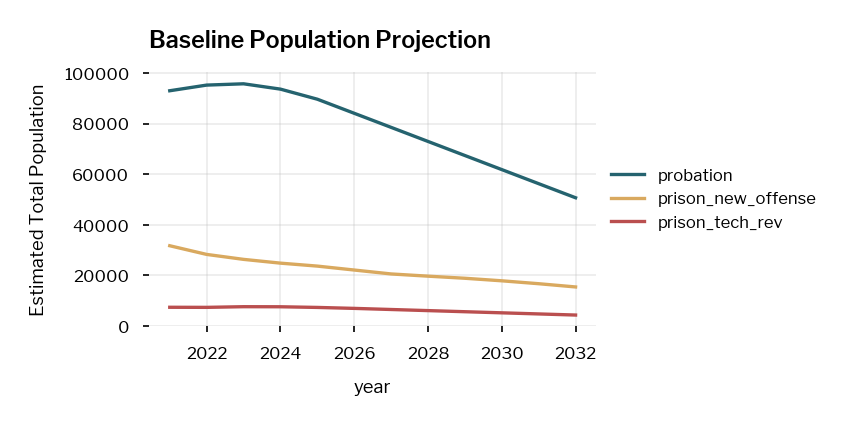

In [17]:
policy_sim.simulate_baseline(["probation", "prison_new_offense", "prison_tech_rev"])
add_legend()

initialization time:  0.6595702171325684
simulation_time:  0.5378808975219727


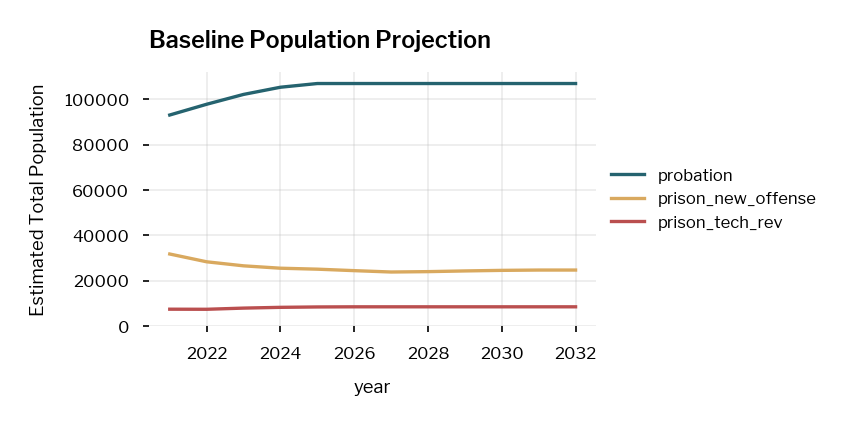

In [5]:
policy_sim.simulate_baseline(["probation", "prison_new_offense", "prison_tech_rev"])
add_legend()

In [41]:
transition_data = policy_sim.initializer.get_data_inputs().transitions_data
probation_transitions = transition_data[
    transition_data["compartment"] == "probation"
].copy()
probation_transitions

,simulation_tag,compartment_duration,compartment,outflow_to,total_population,crime,crime_type,age,race,date_created
0,FL_SB_1378,2.0,probation,probation_completion,0.217572,None,None,x,None,2022-02-23 18:48:13.575406+00:00
1,FL_SB_1378,4.0,probation,probation_completion,0.410287,None,None,x,None,2022-02-23 18:48:13.575406+00:00
7,FL_SB_1378,1.0,probation,prison_tech_rev,0.101639,None,None,x,None,2022-02-23 18:48:13.575406+00:00
8,FL_SB_1378,2.0,probation,prison_tech_rev,0.067175,None,None,x,None,2022-02-23 18:48:13.575406+00:00
9,FL_SB_1378,3.0,probation,prison_tech_rev,0.032127,None,None,x,None,2022-02-23 18:48:13.575406+00:00
10,FL_SB_1378,4.0,probation,prison_tech_rev,0.016356,None,None,x,None,2022-02-23 18:48:13.575406+00:00
11,FL_SB_1378,1.0,probation,prison_new_offense,0.072361,None,None,x,None,2022-02-23 18:48:13.575406+00:00
12,FL_SB_1378,2.0,probation,prison_new_offense,0.047825,None,None,x,None,2022-02-23 18:48:13.575406+00:00
13,FL_SB_1378,3.0,probation,prison_new_offense,0.022873,None,None,x,None,2022-02-23 18:48:13.575406+00:00
14,FL_SB_1378,4.0,probation,prison_new_offense,0.011644,None,None,x,None,2022-02-23 18:48:13.575406+00:00


In [42]:
probation_transitions[probation_transitions["outflow_to"] == "probation_completion"]

,simulation_tag,compartment_duration,compartment,outflow_to,total_population,crime,crime_type,age,race,date_created
0,FL_SB_1378,2.0,probation,probation_completion,0.217572,None,None,x,None,2022-02-23 18:48:13.575406+00:00
1,FL_SB_1378,4.0,probation,probation_completion,0.410287,None,None,x,None,2022-02-23 18:48:13.575406+00:00


In [57]:
# Simulate policy starting in FY 2023
policy_ts = 2

# Policy functions


def apply_probation_credits():
    return partial(
        TransitionTable.apply_reductions,
        reduction_df=pd.DataFrame(
            {
                "outflow": ["probation_completion"],
                "affected_fraction": [0.05],
                "reduction_size": [60 / 365],
            }
        ),
        reduction_type="+",
        retroactive=True,
    )


def reduce_revocations():
    return partial(
        TransitionTable.reallocate_outflow,
        reallocation_df=pd.DataFrame(
            {
                "outflow": ["prison_new_offense"],
                # 46% relative reduction to the 36% revocation rate = 19% rate
                "affected_fraction": [0.05 * 0.19],
                "new_outflow": ["release"],
            }
        ),
        reallocation_type="+",
        retroactive=True,
    )


policy_list = [
    SparkPolicy(
        policy_fn=apply_probation_credits(),
        spark_compartment="probation",
        sub_population={"age": "x"},
        policy_ts=policy_ts,
        apply_retroactive=True,
    ),
    SparkPolicy(
        policy_fn=reduce_revocations(),
        spark_compartment="probation_completion",
        sub_population={"age": "x"},
        policy_ts=policy_ts,
        apply_retroactive=True,
    ),
]

In [140]:
# Simulate policy starting in FY 2023, so it should impact the end-of-FY 2023 values
policy_ts = 1

# Policy functions


def apply_probation_credits():
    return partial(
        TransitionTable.use_alternate_transitions_data,
        alternate_historical_transitions=alternate_policy_transitions,
        retroactive=False,
    )


policy_list = [
    SparkPolicy(
        policy_fn=apply_probation_credits(),
        spark_compartment="probation",
        sub_population={"age": "x"},
        policy_ts=policy_ts,
        apply_retroactive=False,
    ),
]

initialization time:  0.6926498413085938
initialization time:  0.5807812213897705
simulation_time:  0.44615602493286133


simulation_time:  0.45527219772338867
105351.49914777029


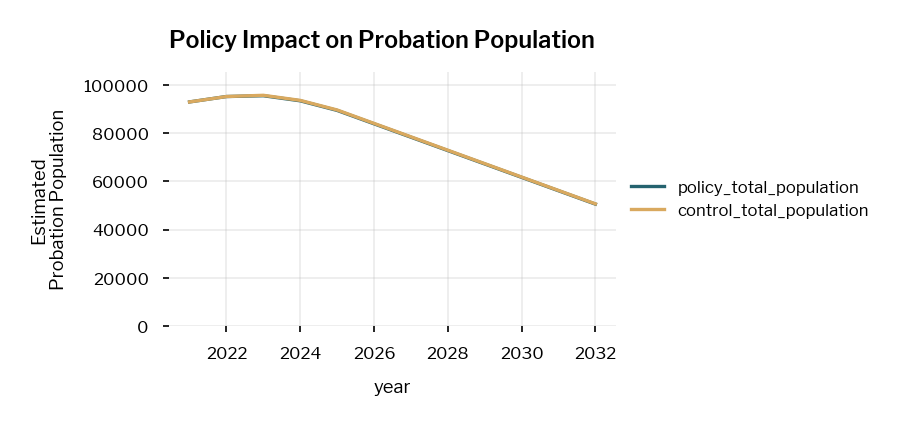

In [58]:
policy_results = policy_sim.simulate_policy(policy_list, "probation")
add_legend()

In [62]:
simulation_tag = "FL_SB_1378"
results_dict = policy_sim.upload_policy_simulation_results_to_bq(simulation_tag)

../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:335: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4447.83it/s]


Text(0.0, 1.0, 'Policy Population Impact')

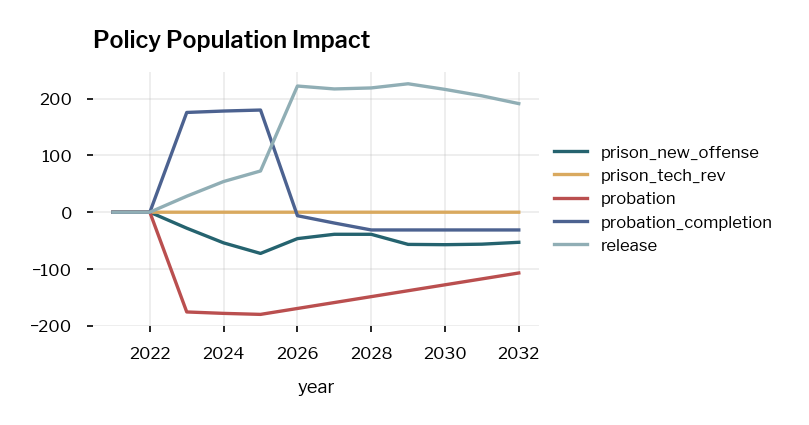

In [63]:
population_results = results_dict["population_diff"].copy()
population_results["population_difference"] = (
    population_results["policy_total_population"]
    - population_results["control_total_population"]
)
population_results.groupby([population_results.index, "compartment"])[
    "population_difference"
].sum().unstack("compartment").plot()
add_legend()
plt.title("Policy Population Impact")

Text(0.0, 1.0, 'Policy Population Impact')

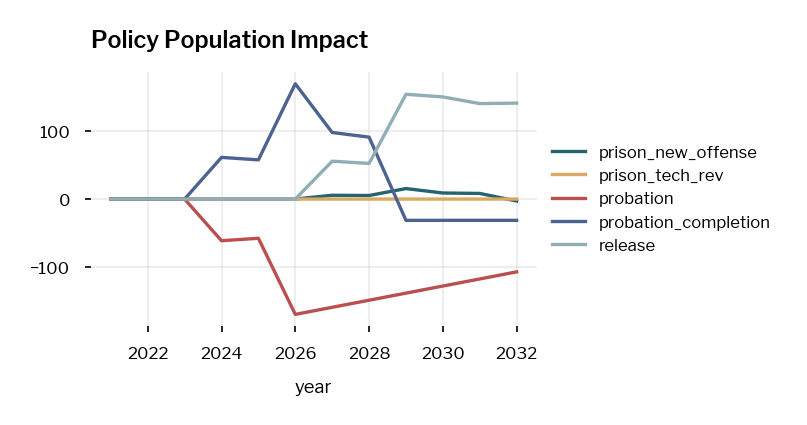

In [32]:
population_results = results_dict["population_diff"].copy()
population_results["population_difference"] = (
    population_results["policy_total_population"]
    - population_results["control_total_population"]
)
population_results.groupby([population_results.index, "compartment"])[
    "population_difference"
].sum().unstack("compartment").plot()
add_legend()
plt.title("Policy Population Impact")

In [20]:
baseline_projection = policy_sim.get_population_simulations()[
    "control"
].get_population_projections()
baseline_outflows = policy_sim.get_population_simulations()["control"].get_outflows()
data_inputs = policy_sim.initializer.get_data_inputs()

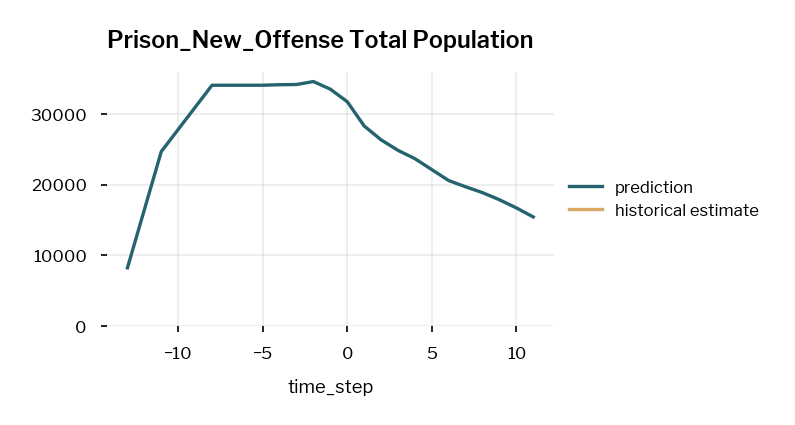

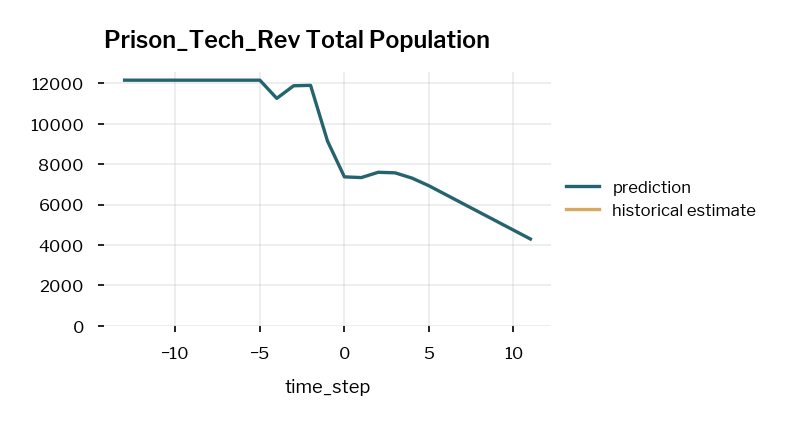

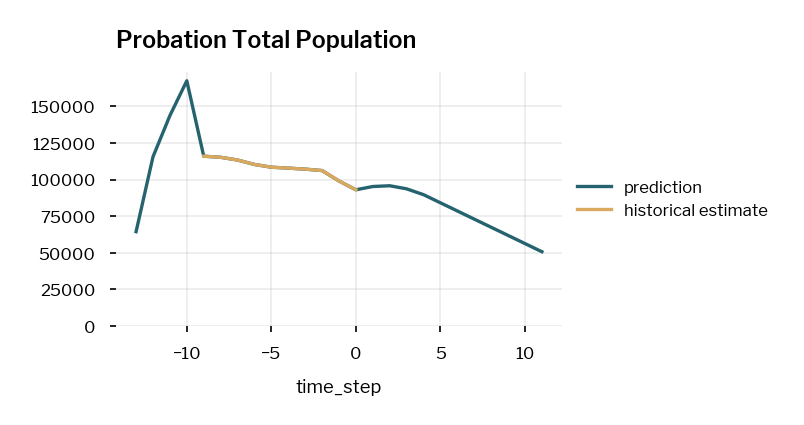

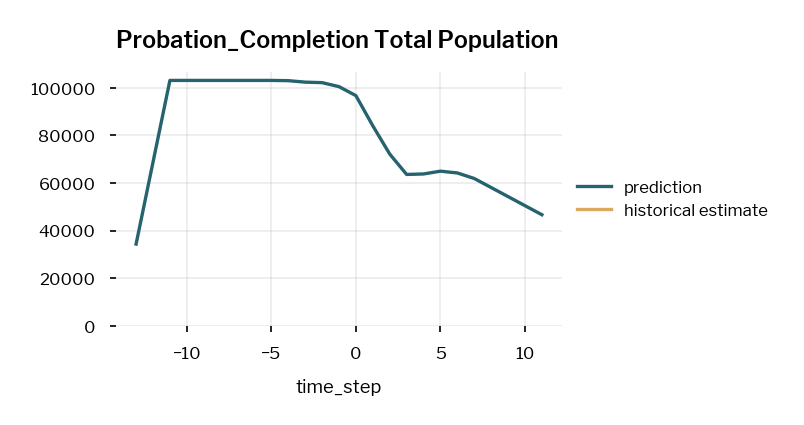

In [21]:
total_population = data_inputs.total_population_data

for compartment, df in baseline_projection.groupby("compartment"):
    if "release" in compartment:
        continue
    plt.figure()
    df.set_index(["time_step"])["total_population"].plot(label="prediction")

    compartment_pop = total_population[total_population["compartment"] == compartment]
    compartment_pop.groupby(["time_step"])["total_population"].sum().plot(
        label="historical estimate"
    )

    add_legend()
    plt.title(f"{compartment.title()} Total Population")
    plt.ylim([0, None])

prison_new_offense
prison_tech_rev
probation
probation_completion
release


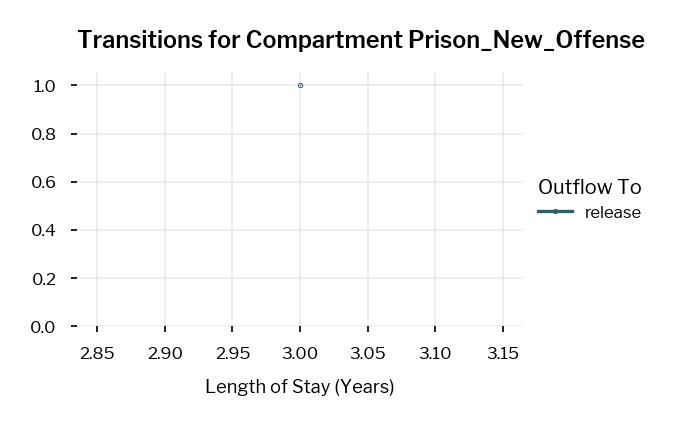

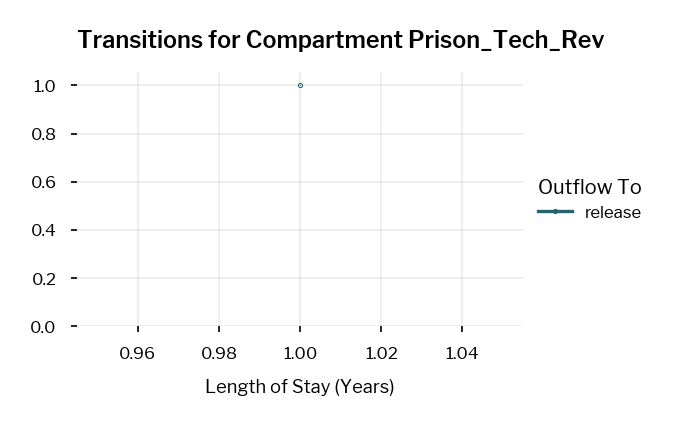

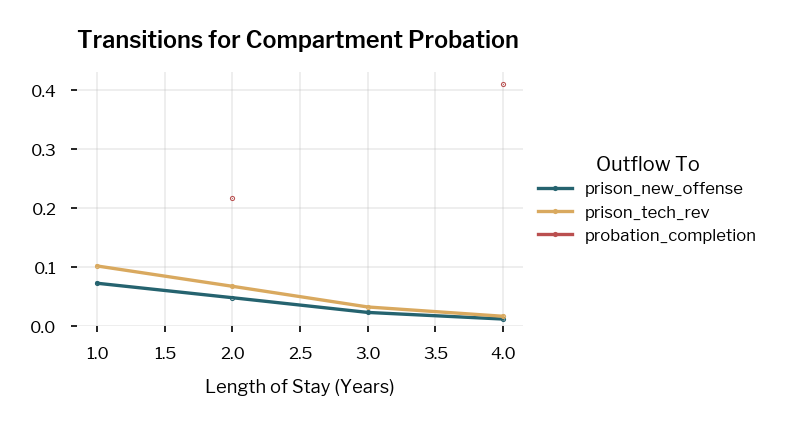

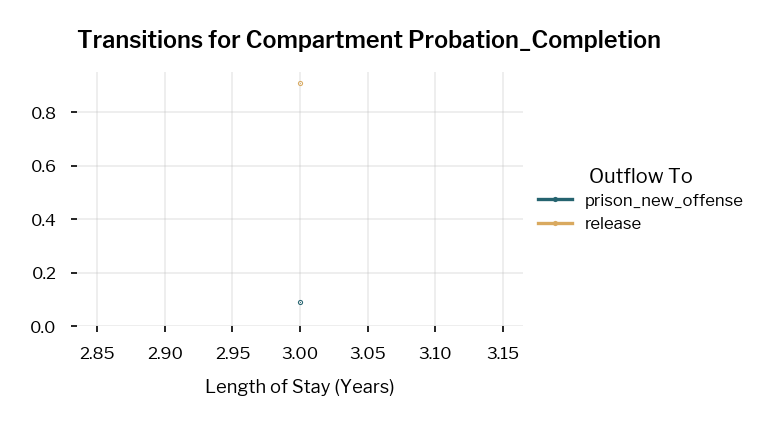

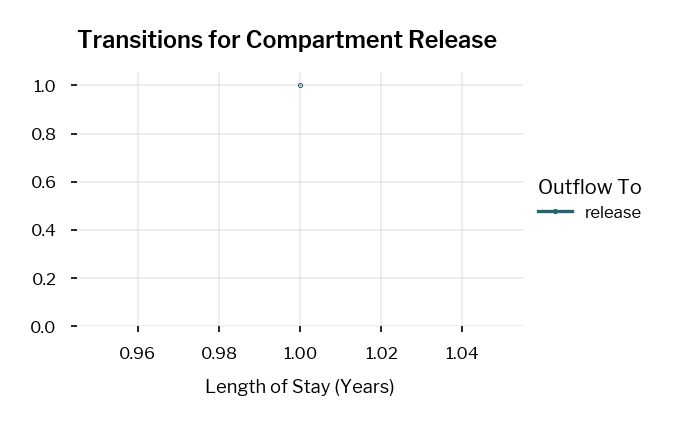

In [40]:
transitions = data_inputs.transitions_data
for compartment, df in transitions.groupby("compartment"):
    if compartment == "release_full":
        continue
    normalization_constant = sum(df["total_population"])
    print(compartment)
    (
        df.set_index(["compartment_duration", "outflow_to"])[
            "total_population"
        ].unstack("outflow_to")
        / normalization_constant
    ).plot(marker=".", markersize="0.5")
    plt.title(f"Transitions for Compartment {compartment.title()}")
    add_legend(title="Outflow To")
    plt.xlabel("Length of Stay (Years)")
    plt.ylim([0, None])

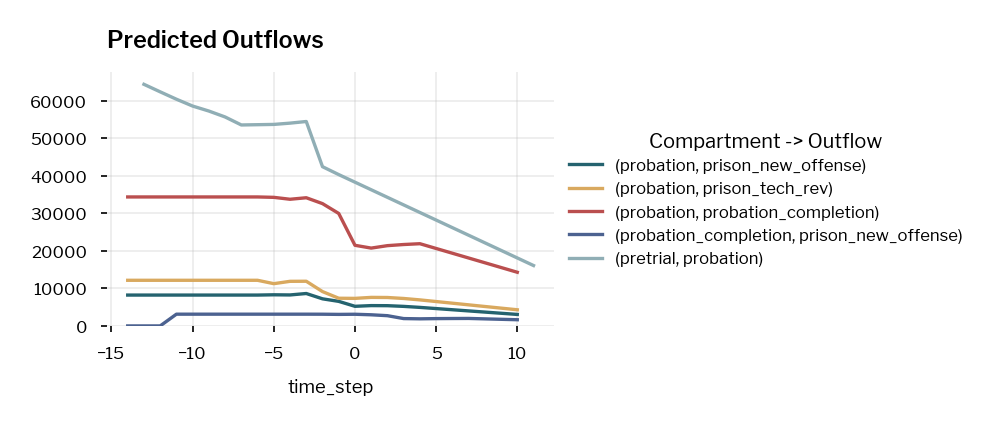

In [23]:
baseline_outflows[
    baseline_outflows.index.get_level_values("outflow_to") != "release"
].groupby(["time_step", "compartment", "outflow_to"])["total_population"].sum().unstack(
    ["compartment", "outflow_to"]
).plot(
    label="Projected"
)
plt.title(f"Predicted Outflows")
plt.ylim([0, None])
add_legend(title="Compartment -> Outflow")

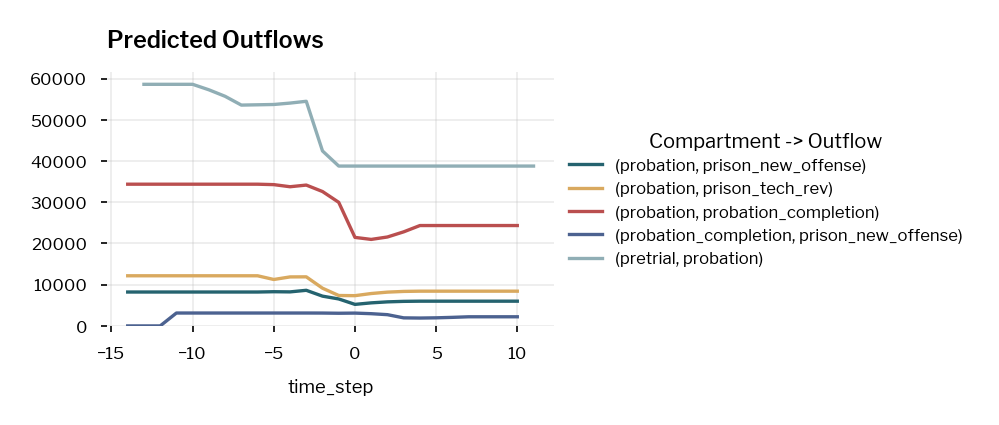

In [28]:
baseline_outflows[
    baseline_outflows.index.get_level_values("outflow_to") != "release"
].groupby(["time_step", "compartment", "outflow_to"])["total_population"].sum().unstack(
    ["compartment", "outflow_to"]
).plot(
    label="Projected"
)
plt.title(f"Predicted Outflows")
plt.ylim([0, None])
add_legend(title="Compartment -> Outflow")

In [116]:
baseline_outflows.loc["probation_completion"]

,total_population,compartment,simulation_group
time_step,,,
-14,34370.977750,probation,x
-13,34370.977750,probation,x
-12,34370.977750,probation,x
-11,34370.977750,probation,x
-10,34370.977750,probation,x
-9,34370.977750,probation,x
-8,34370.977750,probation,x
-7,34370.977750,probation,x
-6,34370.977750,probation,x


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


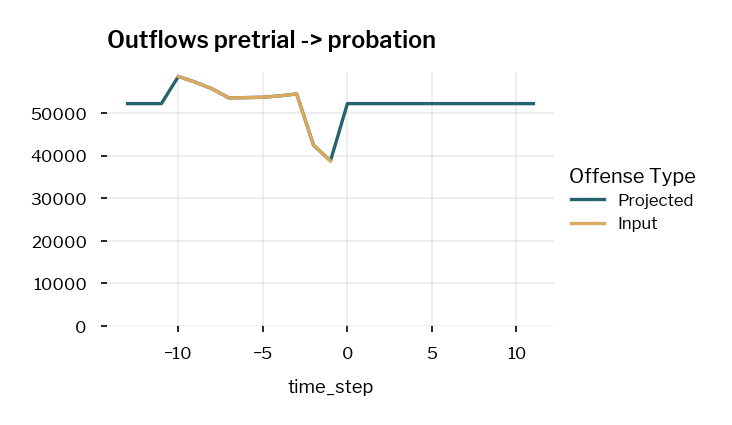

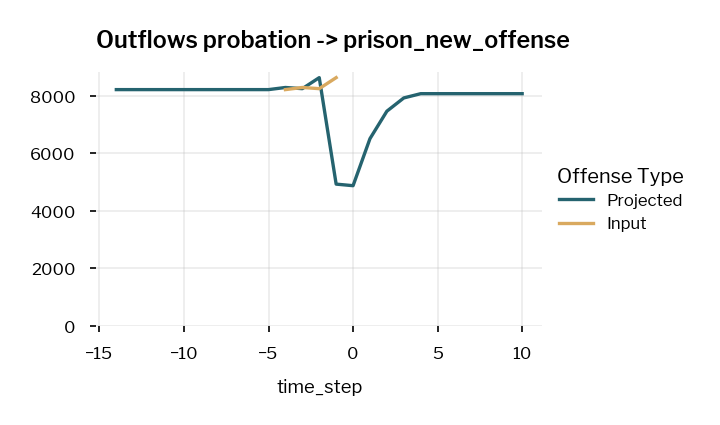

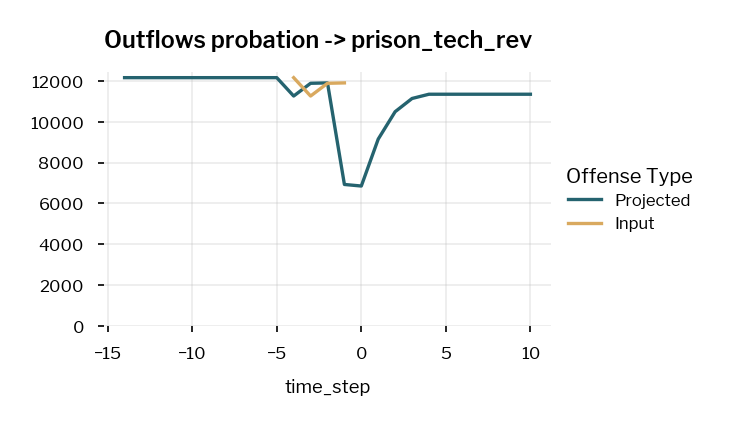

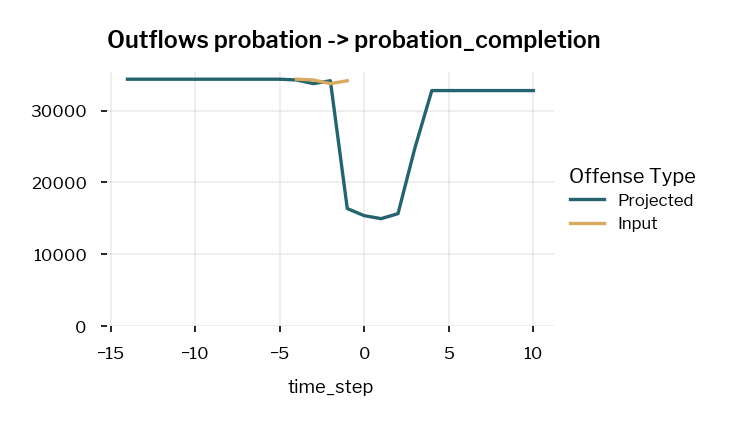

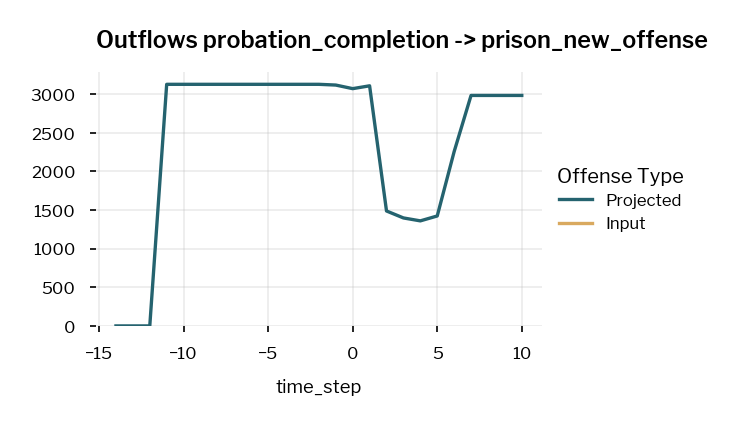

In [17]:
for (compartment, outflow_to), df in baseline_outflows.groupby(
    ["compartment", "outflow_to"]
):
    if outflow_to == "release":
        continue
    plt.figure()
    ax = df.reset_index("outflow_to")["total_population"].plot(label="Projected")

    historical_outflows = outflows[
        (outflows["compartment"] == compartment)
        & (outflows["outflow_to"] == outflow_to)
    ]
    historical_outflows.plot(x="time_step", y="total_population", ax=ax, label="Input")

    add_legend(title="Offense Type")
    plt.title(f"Outflows {compartment} -> {outflow_to}")
    plt.ylim([0, None])

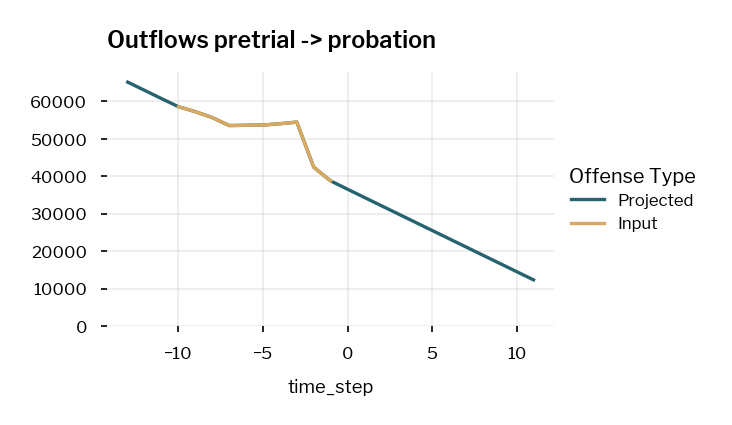

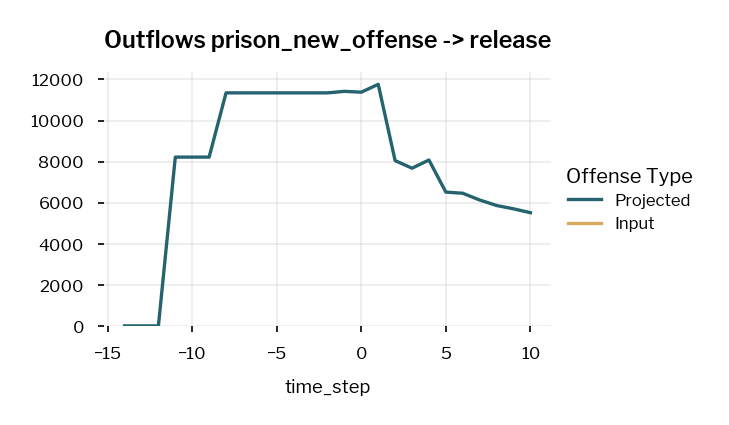

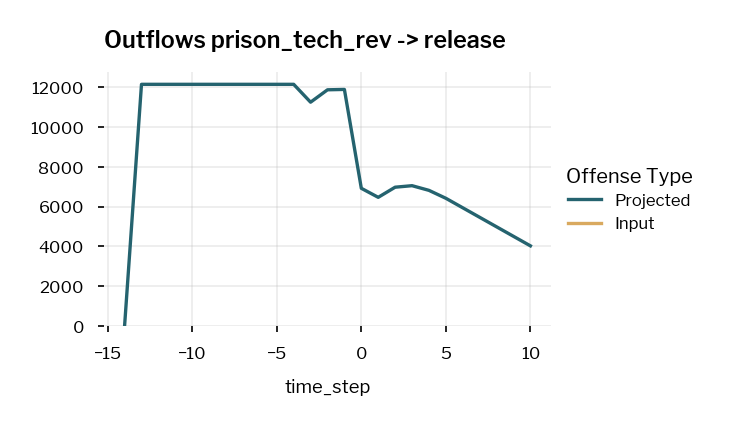

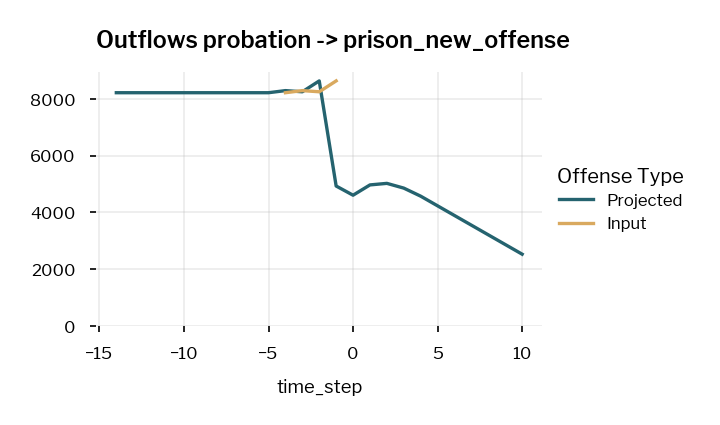

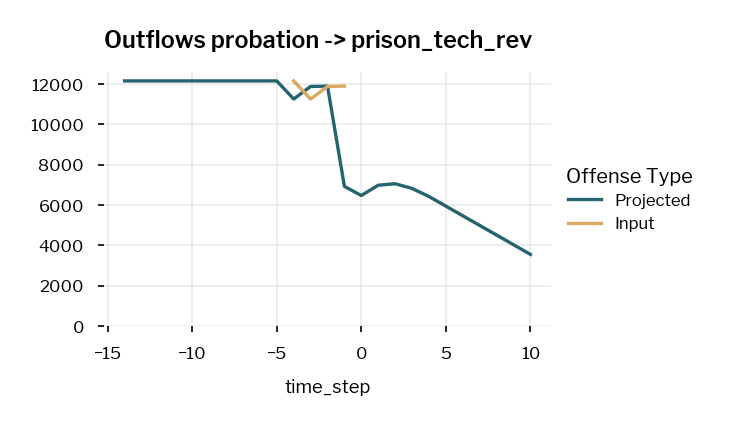

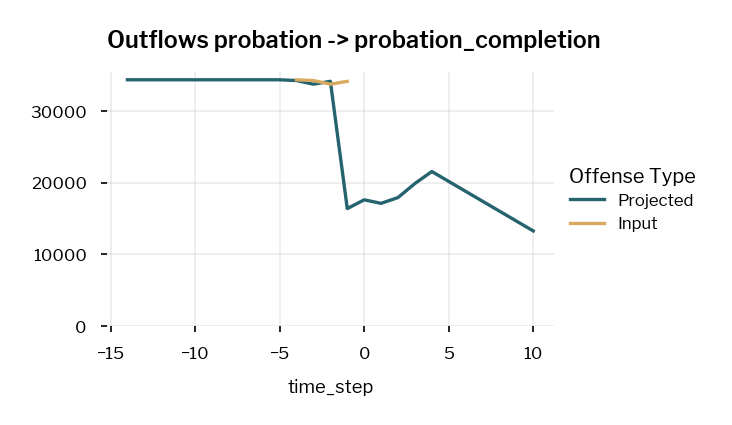

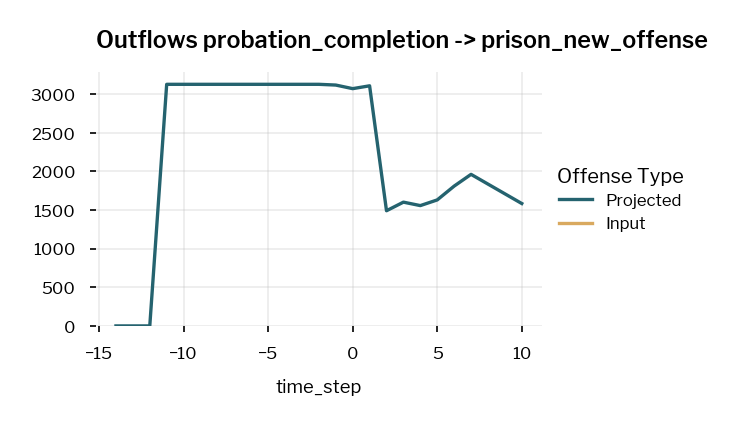

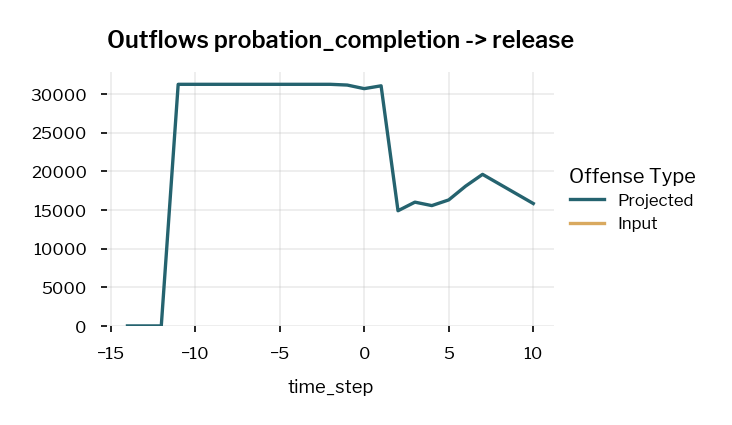

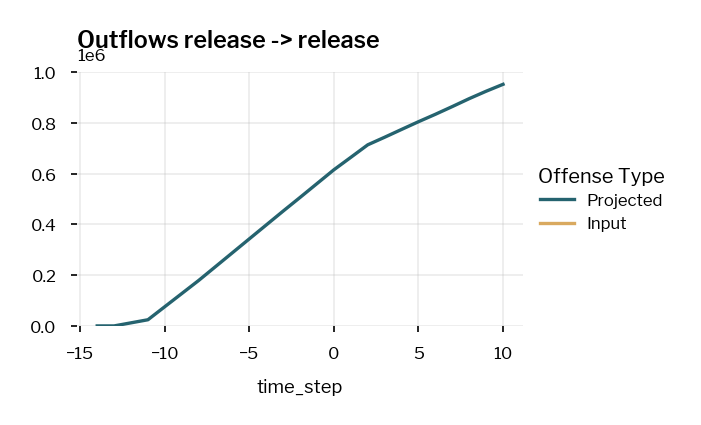

In [11]:
for (compartment, outflow_to), df in baseline_outflows.groupby(
    ["compartment", "outflow_to"]
):
    if outflow_to == "release_full":
        continue
    plt.figure()
    ax = df.reset_index("outflow_to")["total_population"].plot(label="Projected")

    historical_outflows = outflows[
        (outflows["compartment"] == compartment)
        & (outflows["outflow_to"] == outflow_to)
    ]
    historical_outflows.plot(x="time_step", y="total_population", ax=ax, label="Input")

    add_legend(title="Offense Type")
    plt.title(f"Outflows {compartment} -> {outflow_to}")
    plt.ylim([0, None])

In [76]:
predicted_outflows = policy_sim.simulator.pop_simulations[
    "baseline_projections"
].get_outflows()
predicted_outflows.groupby(["compartment", "outflow"])

total_population   compartment simulation_group
outflow_to   time_step                                                 
prison       -18             5045.941842      pretrial                x
             -17             4967.231427      pretrial                x
             -16             4887.825920      pretrial                x
             -15             4806.965459      pretrial                x
             -14             4723.059514      pretrial                x
...                                  ...           ...              ...
release_full  8            169973.234769  release_full                x
              9            183458.153217  release_full                x
              10           197445.314333  release_full                x
              11           212392.922519  release_full                x
              12           228227.369093  release_full                x

[224 rows x 3 columns]

In [145]:
policy_sim.get_population_simulations()["baseline_projections"]\
    .sub_simulations["x"].simulation_compartments["probation"]
    .compartment_transitions

policy_ts 2


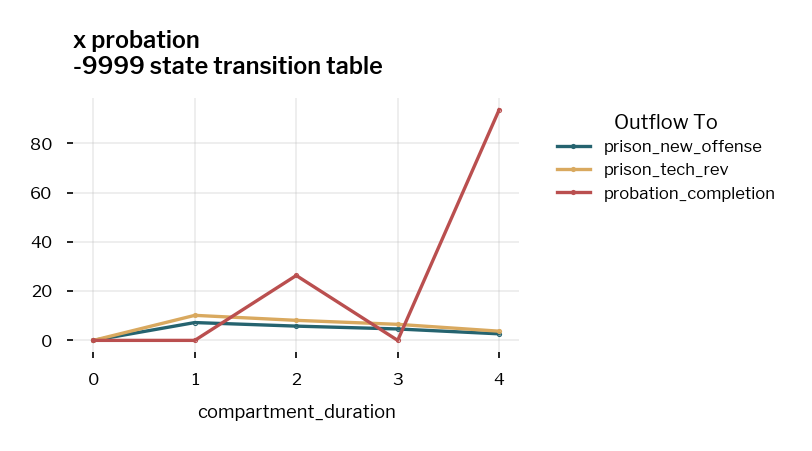

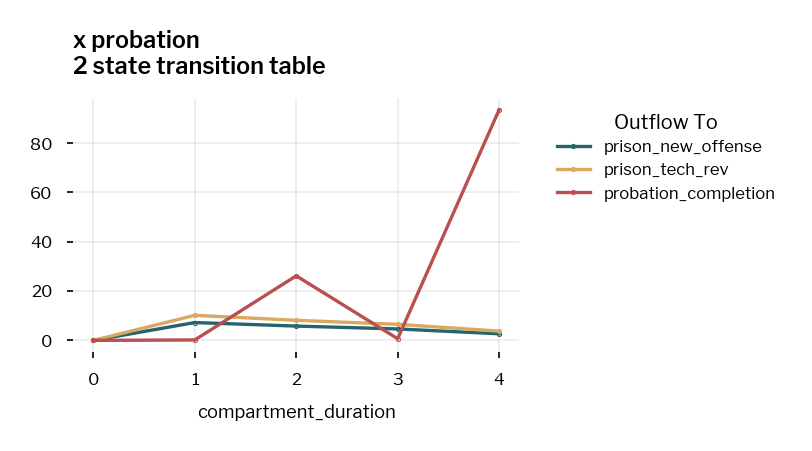

In [34]:
simulation_key = "policy"
compartment = "probation"
for age, sub_sim in policy_sim.get_population_simulations()[
    simulation_key
].sub_simulations.items():
    spark_compartment = sub_sim.simulation_compartments[compartment]

    policy_ts = max(spark_compartment.compartment_transitions.transition_tables.keys())
    print(f"policy_ts {policy_ts}")
    for (
        time_step,
        transition_df,
    ) in spark_compartment.compartment_transitions.transition_tables[
        policy_ts
    ].tables.items():
        transition_df = pd.DataFrame(
            (transition_df.drop(["remaining"], axis=1) * 100).stack("outflow_to"),
            columns=["transition_percent"],
        )
        transition_df["age"] = age
        transition_df["compartment"] = compartment
        transition_df["time_step"] = time_step
        transition_df = (
            transition_df.set_index(["time_step", "compartment", "age"], append=True)
            .reorder_levels(
                [
                    "time_step",
                    "compartment",
                    "age",
                    "compartment_duration",
                    "outflow_to",
                ]
            )
            .unstack("outflow_to")
        )

        title = f"{age} {compartment}\n{time_step} state transition table"

        ax_list = transition_df.loc[time_step, compartment, age].plot(
            y="transition_percent", title=title, marker=".", markersize=0.5
        )
        plt.legend(title="Outflow To", bbox_to_anchor=(1.05, 1), loc="upper left")

In [71]:
transition_df

transition_percent  \
outflow_to                                     prison_new_offense   
time_step compartment age compartment_duration                      
2         probation   x   1                               7.23712   
                          2                               5.80351   
                          3                               4.63685   
                          4                               2.67731   

                                                                \
outflow_to                                     prison_tech_rev   
time_step compartment age compartment_duration                   
2         probation   x   1                           10.16533   
                          2                            8.15161   
                          3                            6.51284   
                          4                            3.76074   

                                                                     
outflow_to                                     probation_completion  
time_step compartment age compartment_duration                       
2         probation   x   1                                 0.17885  
                          2                                26.18510  
                          3                                 0.68362  
                          4                                93.56196

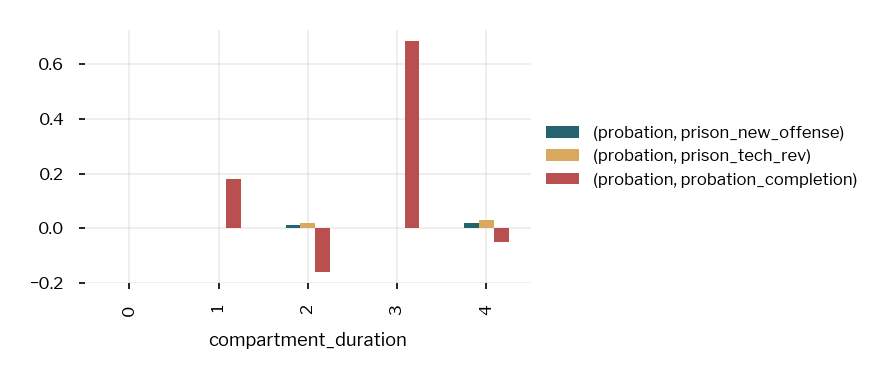

In [35]:
compartment = "probation"
policy_transitions = pd.DataFrame()
for (
    time_step,
    transition_df,
) in spark_compartment.compartment_transitions.transition_tables[
    policy_ts
].tables.items():
    transition_df = pd.DataFrame(
        (transition_df.drop(["remaining"], axis=1) * 100).stack("outflow_to"),
        columns=["transition_percent"],
    )
    transition_df["time_step"] = time_step
    transition_df["compartment"] = compartment
    #     transition_df = transition_df.set_index(['time_step', 'compartment'], append=True).reorder_levels(
    #         ['compartment_duration', 'outflow_to'])
    policy_transitions = pd.concat([policy_transitions, transition_df])

policy_transitions = (
    policy_transitions.set_index(["time_step", "compartment"], append=True)
    .reorder_levels(["time_step", "compartment", "compartment_duration", "outflow_to"])
    .unstack("time_step")
)
(
    policy_transitions["transition_percent", 2]
    - policy_transitions["transition_percent", -9999]
).unstack(["compartment", "outflow_to"]).plot.bar()
add_legend()

In [38]:
new_probation_transitions = pd.DataFrame(
    pd.concat(
        [
            policy_transitions["transition_percent", 2].loc[
                "probation", :, ["probation_completion"]
            ],
            policy_transitions["transition_percent", -9999].loc[
                "probation", :, ["prison_new_offense", "prison_tech_rev"]
            ],
        ]
    )
)
remaining_column = new_probation_transitions.groupby(
    ["compartment", "compartment_duration"]
).sum()
remaining_column.columns = ["remaining"]
new_probation_transitions = (
    pd.concat(
        [
            new_probation_transitions.unstack("outflow_to").droplevel(0, axis=1),
            remaining_column,
        ],
        axis=1,
    ).reset_index("compartment", drop=True)
    / 100
)
alternate_policy_transitions = TransitionTable._unnormalized_table(
    new_probation_transitions
)
alternate_policy_transitions = pd.melt(
    alternate_policy_transitions.reset_index(drop=False),
    id_vars=["compartment_duration"],
    value_vars=["prison_new_offense", "prison_tech_rev", "probation_completion"],
    value_name="total_population",
    var_name="outflow_to",
)
alternate_policy_transitions

,compartment_duration,outflow_to,total_population
0,0,prison_new_offense,0.000000
1,1,prison_new_offense,0.072371
2,2,prison_new_offense,0.047728
3,3,prison_new_offense,0.022888
4,4,prison_new_offense,0.011562
5,0,prison_tech_rev,0.000000
6,1,prison_tech_rev,0.101653
7,2,prison_tech_rev,0.067039
8,3,prison_tech_rev,0.032148
9,4,prison_tech_rev,0.016241
